# Alcoholic spaces Scanner

## Introduction



In this project I have pointed out the places in Bucharest that are alcoholic or not for teenagers less than 18 years old.

There are many parents who want their children to be safe and practice the rules and regulations of the country. they should not be drinking before the legal age of the country. In this project I have made an analysis about various places that are suitable for the youth as well as the drinking sites.


## Data
Data was available at wikipedia for Bucharest

Links are:

-  "https://en.wikipedia.org/wiki/Category:Districts_of_Bucharest"

-  "https://en.wikipedia.org/wiki/Sectors_of_Bucharest"

### Installing libraries and packages

In [1]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

In [2]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install BeautifulSoup4

In [4]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [8]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest1_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [11]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


In [12]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors_of_Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [13]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [14]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.485790,26.101219
1,Băneasa,Sector 1,"225,454",44.494012,26.080358
2,Berceni,Sector 4,"287,828",44.386430,26.128490
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660


In [15]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

In [17]:
# @hidden_cell
            CLIENT_ID="Q5SAY0XAYHJ2KXJ3AIRKQJ2IPWSWFCPR5FOA5OFWCBE2DEUF"
            CLIENT_SECRET="HK1XAI1VDMPCZWIXOUIUPVJ0ECGRR1OJTE0MEKZIBVRH5PGW"
            VERSION="20180605"


In [18]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 224 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
1,Aviației,44.48579,26.101219,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
2,Aviației,44.48579,26.101219,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.101219,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop
4,Aviației,44.48579,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint


In [22]:
print('Top 100 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:100]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,69
Restaurant,65
Coffee Shop,59
Italian Restaurant,56
Pizza Place,52
Supermarket,52
Gym,39
Hotel,39
Romanian Restaurant,38


In [27]:
restaurant_list =['Convenience Store', 'Dance Studio','Bar',
                  'Casino','Theater','Gym / Fitness Center','Gym','Beer Bar','Wine Shop','Chocolate Shop','Garden','Multiplex',
                  'Food & Drink Shop', 'Cocktail Bar']
turkish_restaurant_list = ['Bar','Beer Bar','Wine Shop','Food & Drink Shop', 'Cocktail Bar',  'Casino']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of youth enjoyment places:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of alcoholic places :', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of alcoholic places: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of youth enjoyment places: 179
Total number of alcoholic places : 36
Percentage of alcoholic places: 20.11%


11 neighborhoods do not have any alcoholic places


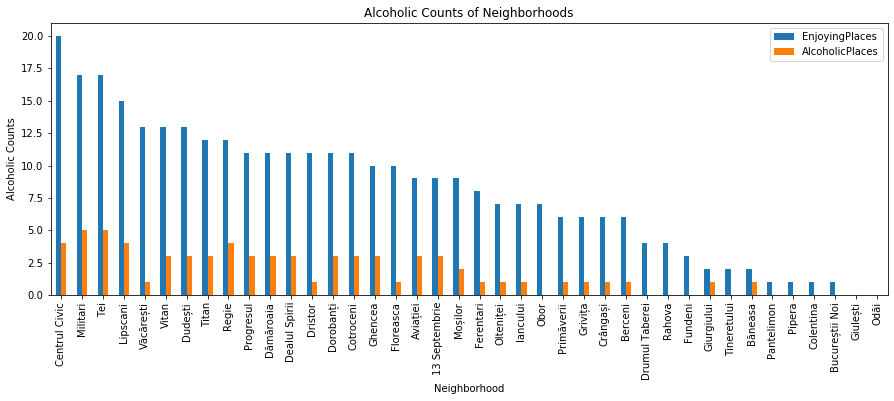

In [35]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "EnjoyingPlaces"})[['EnjoyingPlaces']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'EnjoyingPlaces': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "AlcoholicPlaces"})[['AlcoholicPlaces']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'AlcoholicPlaces': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['EnjoyingPlaces'],ascending =False)

print('{} neighborhoods do not have any alcoholic places'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['EnjoyingPlaces','AlcoholicPlaces']].plot(kind='bar',figsize=(15,5))
plt.title('Alcoholic Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Alcoholic Counts')
plt.show()


In [36]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,4d7731aebc888cfac2f5e573,7.6,4.0
1,5abf8bf49fca567ea381ee43,7.5,23.0
2,5dde6a94af03f30008bfeb22,7.5,0.0
3,529e0ff211d2ee9c61e157e7,7.7,55.0
4,525d091a498edd52e72a51e4,6.6,8.0


In [37]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Toni&Guy,4d7731aebc888cfac2f5e573,44.484375,26.092021,747,Salon / Barbershop,7.6,4.0
1,Aviației,44.485790,26.101219,Hangar Gastrobar,5abf8bf49fca567ea381ee43,44.480385,26.105761,701,Beer Garden,7.5,23.0
2,Floreasca,44.476308,26.103289,Hangar Gastrobar,5abf8bf49fca567ea381ee43,44.480385,26.105761,494,Beer Garden,7.5,23.0
3,Aviației,44.485790,26.101219,World Class Romania,5dde6a94af03f30008bfeb22,44.480482,26.106822,739,Gym / Fitness Center,7.5,0.0
4,Floreasca,44.476308,26.103289,World Class Romania,5dde6a94af03f30008bfeb22,44.480482,26.106822,542,Gym / Fitness Center,7.5,0.0


In [38]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Toni&Guy,4d7731aebc888cfac2f5e573,44.484375,26.092021,747,Salon / Barbershop,7.6,4.0
1,Aviației,44.485790,26.101219,Hangar Gastrobar,5abf8bf49fca567ea381ee43,44.480385,26.105761,701,Beer Garden,7.5,23.0
2,Floreasca,44.476308,26.103289,Hangar Gastrobar,5abf8bf49fca567ea381ee43,44.480385,26.105761,494,Beer Garden,7.5,23.0
3,Aviației,44.485790,26.101219,World Class Romania,5dde6a94af03f30008bfeb22,44.480482,26.106822,739,Gym / Fitness Center,7.5,0.0
4,Floreasca,44.476308,26.103289,World Class Romania,5dde6a94af03f30008bfeb22,44.480482,26.106822,542,Gym / Fitness Center,7.5,0.0


In [64]:
data=neighborhood_restaurants[['VenueLatitude','VenueLongitude']]
data.head()
#data.dtypes

,VenueLatitude,VenueLongitude
0,44.484375,26.092021
1,44.480385,26.105761
2,44.480385,26.105761
3,44.480482,26.106822
4,44.480482,26.106822


In [65]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(data).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

TypeError: must be real number, not str

In [66]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

TypeError: must be real number, not str

In [67]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 224 columns as below


,Neighborhood,Hotel,Supermarket,Coffee Shop,Burger Joint,Dessert Shop,Roof Deck,Grocery Store,Vietnamese Restaurant,Salad Place,Salon / Barbershop,Bookstore,Beer Garden,Gym / Fitness Center,Restaurant,Steakhouse,Café,Pie Shop,Bakery,Shopping Mall,Italian Restaurant,Clothing Store,Sushi Restaurant,Turkish Restaurant,Toy / Game Store,Lebanese Restaurant,Sandwich Place,Spanish Restaurant,Casino,Pizza Place,Middle Eastern Restaurant,Event Space,Indoor Play Area,Lounge,Eastern European Restaurant,Fried Chicken Joint,Farmers Market,Stadium,Gym,Romanian Restaurant,Lighting Store,Mongolian Restaurant,Tennis Stadium,Chinese Restaurant,Ice Cream Shop,Sporting Goods Shop,Cocktail Bar,Cupcake Shop,Food & Drink Shop,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Nightclub,Park,Theme Restaurant,Tunnel,Bed & Breakfast,Soccer Field,Electronics Store,Nature Preserve,Fast Food Restaurant,Pharmacy,Fountain,Metro Station,Gas Station,Mobile Phone Shop,Spa,Korean Restaurant,Shop & Service,Bistro,Outdoor Sculpture,Gastropub,Theater,Monastery,Indie Theater,Skating Rink,Beer Bar,Used Bookstore,Chocolate Shop,Tea Room,Art Museum,Bar,Wine Bar,Concert Hall,Plaza,Cosmetics Shop,Rock Club,Swiss Restaurant,Hostel,Historic Site,Art Gallery,Tattoo Parlor,Mediterranean Restaurant,Church,History Museum,Gourmet Shop,Boutique,French Restaurant,Garden,Hardware Store,Discount Store,Arts & Crafts Store,Bus Station,Furniture / Home Store,Gift Shop,Tennis Court,Accessories Store,Jazz Club,Market,Opera House,Hotel Bar,Pub,Indian Restaurant,Music Store,Pool,Pedestrian Plaza,Indie Movie Theater,Australian Restaurant,Martial Arts Dojo,Light Rail Station,Department Store,Climbing Gym,Soccer Stadium,Miscellaneous Shop,Sake Bar,Convenience Store,Outlet Mall,Veterinarian,Mexican Restaurant,Flower Shop,Fish Market,Japanese Restaurant,Juice Bar,Scandinavian Restaurant,Cheese Shop,Asian Restaurant,Modern European Restaurant,Seafood Restaurant,Creperie,Wine Shop,German Restaurant,Molecular Gastronomy Restaurant,Hookah Bar,American Restaurant,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Skate Park,Greek Restaurant,Water Park,Brewery,Playground,Ballroom,Tourist Information Center,Bus Line,Butcher,Health & Beauty Service,Health Food Store,Camera Store,Bagel Shop,Falafel Restaurant,Diner,Auto Dealership,Portuguese Restaurant,Science Museum,Perfume Shop,Snack Place,Lingerie Store,Ramen Restaurant,Cafeteria,Tram Station,Boxing Gym,Museum,Food Truck,Buffet,Movie Theater,Kebab Restaurant,Exhibit,Public Art,Pool Hall,RV Park,Women's Store,Palace,Cultural Center,Football Stadium,Shoe Store,BBQ Joint,Hungarian Restaurant,Karaoke Bar,Donut Shop,Beach,Auto Garage,Currency Exchange,Athletics & Sports,Sports Club,Food,Go Kart Track,IT Services,Souvlaki Shop,Track,Gym Pool,Recreation Center,Bike Shop,Basketball Court,Paper / Office Supplies Store,Bowling Alley,Sports Bar,Laundromat,Baby Store,Comfort Food Restaurant,Taco Place,Watch Shop,Smoke Shop,Fish & Chips Shop,Betting Shop,ATM,Soup Place,Circus,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe,Recording Studio
0,13 Septembrie,2,3,1,0,0,0,0,0,0,0,0,0,2,5,1,4,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,2,0,1,1,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,2,1,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0
1,Aviației,4,4,3,3,2,1,1,1,1,1,1,1,2,7,3,5,1,5,1,1,4,2,1,1,2,1,1,1,4,1,1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ber

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,69,Restaurant,Plaza,Café,Supermarket,Pub,Hotel,Lounge,Seafood Restaurant,Tea Room,Romanian Restaurant
1,Aviației,86,Restaurant,Bakery,Café,Hotel,Supermarket,Pizza Place,Clothing Store,Steakhouse,Burger Joint,Coffee Shop
2,Berceni,27,Pizza Place,Coffee Shop,Pharmacy,Grocery Store,Gym,Farmers Market,Eastern European Restaurant,Gym / Fitness Center,Hotel,Italian Restaurant
3,Bucureștii Noi,11,Spa,Supermarket,Gym,Metro Station,Park,Gas Station,Mobile Phone Shop,Farmers Market,Korean Restaurant,Shop & Service
4,Băneasa,27,Hotel,Café,Restaurant,Romanian Restaurant,Italian Restaurant,Doner Restaurant,Pizza Place,Middle Eastern Restaurant,Farmers Market,Food & Drink Shop


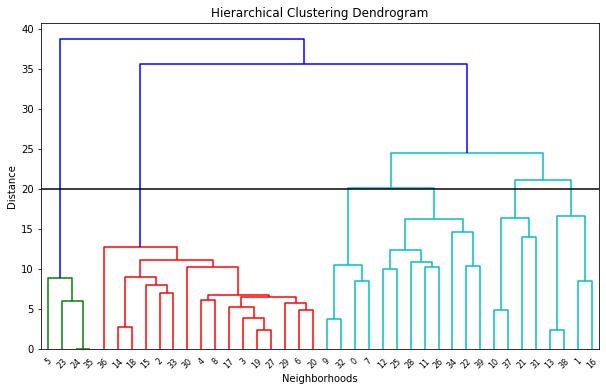

In [69]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [70]:

from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.485790,26.101219,0,Restaurant,Bakery,Café
1,Băneasa,Sector 1,"225,454",44.494012,26.080358,2,Hotel,Café,Restaurant
2,Berceni,Sector 4,"287,828",44.386430,26.128490,2,Pizza Place,Coffee Shop,Pharmacy
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807,2,Spa,Supermarket,Gym
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660,3,Coffee Shop,Hotel,Theater


In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [74]:
#print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Bakery                                       1
                    Coffee Shop                                  1
                    Lounge                                       2
1                   Coffee Shop                                  2
                    Lounge                                       1
                    Restaurant                                   1
2                   Bar                                          1
                    Bus Station                                  1
                    Café                                         2
                    Coffee Shop                                  1
                    Dessert Shop                                 1
                    Fast Food Restaurant                         1
                    Gym / Fitness Center                         1
                    Middle Eastern Restaurant                    1
                    Pizza Place                                  1
                    Pub                                          1
                    Romanian Restaurant                          1
                    Sandwich Place                               1
                    Soccer Field                                 2
                    Supermarket                                  1
3                   Hotel                                        4
4                   Burger Joint                                 1
                    Café                                         1
                    Clothing Store                               1
                    Italian Restaurant                           1
                    Pizza Place                                  1
                    Romanian Restaurant                          1
                    Supermarket                                  2
5                   Bus Station                                  2
                    Hotel                                        1
                    Plaza                                        1

## Methodology

I have used various data from wikipedia to analyze the places around Bucharest and counted number of safe places and drinking places.
analysis is the data was done by seeing the ratings and all.
Then I used Maps and got errors. 
On the map the points depict the places or neighbourhoods segregated or clustered.

## Result

The cyan coloured places are dry and safe for the teenagers less than 18 years old.


# Conclusion

The places center to Bucharest are less alcoholic places. Parents can send their kids to these places.
these are safe and dry places

In [1]:
#SofiaSunam